## Import code

In [31]:
%load_ext autoreload
%autoreload 2 
# Autoreloads packages when changes are detected

from src.Data import * # Class containing the data
from src.Assignment import * # Class containing an assignment
from src.Model import * # Class containing a Pulp model used for optimization
from src.ModelColumnGen import * # Class containing Pulp model that optimizes using column generation
from src.ModelFracStable import * # Class containing a Pulp model for finding an fractionally stable stochastic improvement
from src.ModelHeuristicLP import * # Class containing heuristic that will use generated weakly stable matchings as an input
from src.DataGen import * # Generate student preferences and school priorities
from src.DataGenEE import * # Generate data according to the method by Erdil & Ergin (2008)
from src.DA_STB import * # Generate DA assignment with single tie-breaking (STB)
from src.ErdilErgin import * # Erdil & Ergil their implementation of Stable Improvement Cycles algorithm + alternative implementation DA
from src.SICs import * # Adaptation of SICs algorithm to our code
from src.Simulations import * # Run solution methods for multiple data instances
from src.SimulationsEvaluate import * # Functions that evaluate simulation results

from ReadData.Estonia.Estonia import * # Read Estonian data

import pickle # to export data

# If you get error that pulp and gurobipy are not installed: uncomment following lines in src/Data file:(keep exclamation marks)
    #! pip install pulp
    #! pip install gurobipy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Column generation formulation

In [2]:
# Generate random data
parameters = DataGenParam(mean_pref = 5, capacity_ratio = 1) # Default parameters, except for mean_pref and capacity_ratio
#MyData = generate_data(n_students=400, n_schools=20, parameters = parameters, name="Test_DataGen", print_data=False, seed = 15)
#[n_students,n_schools,seed] = [40,10,10]
#[n_students,n_schools,seed] = [50,12,10] # Nice, good illustration of results!
#[n_students,n_schools,seed] = [35,15,0] # Clean simple example where EE has no improvement and we have
[n_students,n_schools,seed] = [200,15,10] # Larger. No improvement upon heuristic. But still, heuristic improves quite a lot on EE (93 instead of 90, avg 0.43 instead of 0.38 improvement)
name = str(n_students) + "_" + str(n_schools) + "_" + str(seed)
MyData = generate_data(n_students = n_students, n_schools=n_schools, parameters = parameters, name=name, print_data=False, seed = seed)

In [ ]:
# Print data if desired
print(MyData)

In [3]:
# Generate the assignment from DA with Single Tie-Breaking with n_iter samples
n_iter = 400
bool_SIC = False # Run SICs immediately?
A = DA_STB(MyData, n_iter, 'GS', bool_SIC, 0, True)

# Find Stable improvement cycles à la Erdil and Ergin (2008)
A_SIC = SIC_all_matchings(MyData, A, True)

Students in ties: 200
Tie-breaking rules sampled: 400


Generate DA_STB: 100%|██████████| 400/400 [00:17<00:00, 22.98perturb/s]


STATISTICS BEFORE:

Average rank: 1.7030249999999996.



Compute SICs for matchings: 100%|██████████| 400/400 [00:01<00:00, 382.03matching/s]


STATISTICS AFTER:

Average rank: 1.5292624999999906.



In [10]:
# Solve the formulations
MyModel = ModelColumnGen(MyData, A_SIC, A.assignment, True)
    # Will use matchings in A_SIC to sd_dominate the assignment 'A.assignment' (found by DA)
    
S = MyModel.Solve("TRAD", "GUROBI", print_log=True, time_limit= 20, print_out=True)
#q = MyModel.Solve("STABLE", "GUROBI", True)

Master: add decision variables: 100%|██████████| 400/400 [00:00<00:00, 404.38var/s]



Average rank DA : 1.7030249999999996.


Average rank warm start solution : 1.5292624999999906.




Pricing exclude found matchings: 100%|██████████| 400/400 [00:02<00:00, 154.18matchings/s]


Number of matchings: 400
ITERATION: 1

 ****** MASTER ****** 

Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (22631.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-1185G7 @ 3.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 855 rows, 400 columns and 260657 nonzeros
Model fingerprint: 0x07ef89ed
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-03, 1e+00]
Presolve removed 681 rows and 0 columns
Presolve time: 0.03s
Presolved: 174 rows, 400 columns, 40165 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.3550000e+00   1.772500e+01   0.000000e+00      0s
     296    1.5016984e+00   0.000000e+00   0.000000e+00      0s

Solved in 296 iterations and 0.05 seconds (0.10 work units)
Optimal objective  1.501698426e+00
Gurobi status= 2
Objective

In [11]:
print(S.A.assignment)
print(S.Xdecomp)
print(S.Xdecomp_coeff)

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.96806937 0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.51958869 0.         ... 0.29945786 0.08563801 0.        ]]
[array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]]), array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]]), array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 

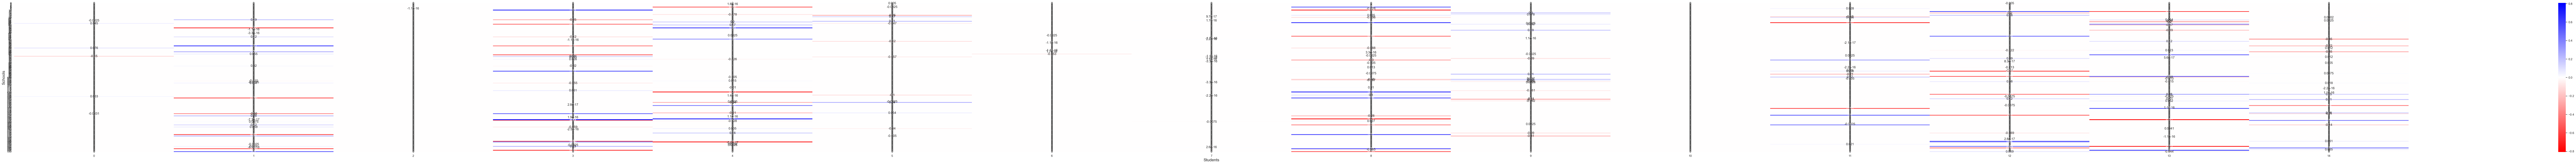

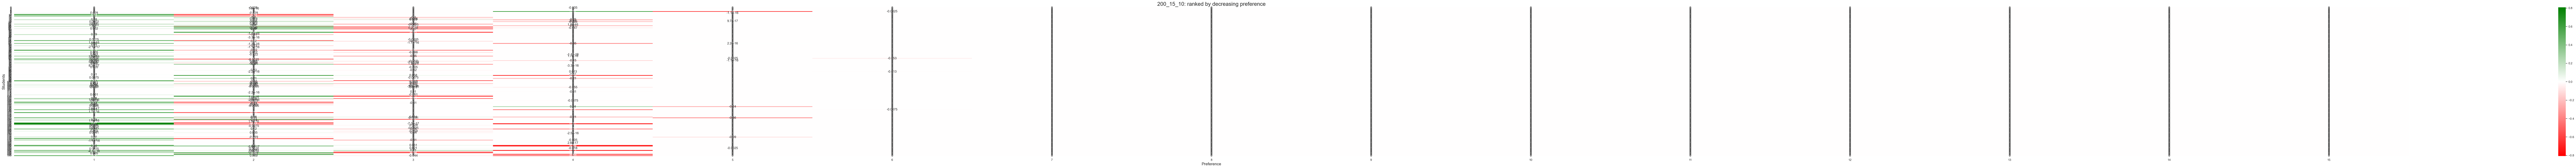

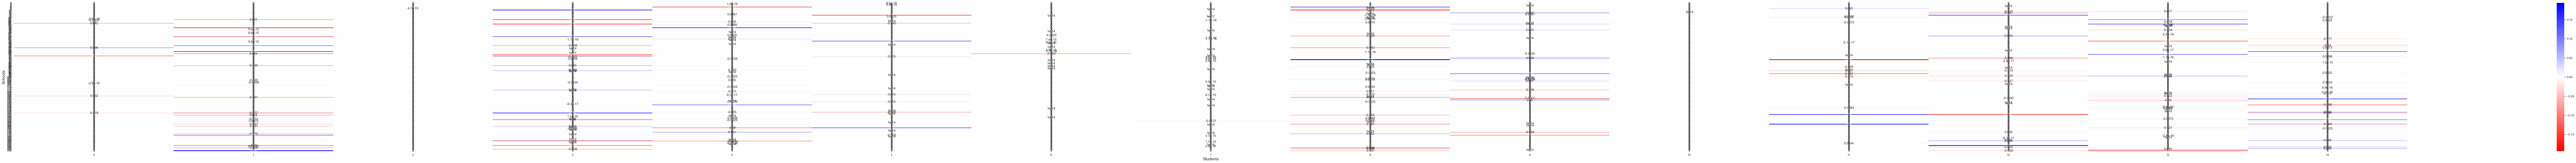

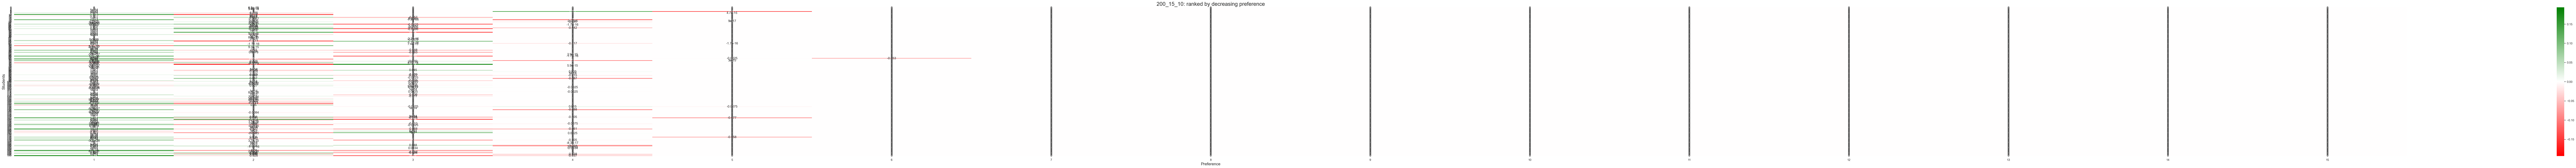

<Figure size 20000x1000 with 0 Axes>

In [12]:
# Asses and visualize the difference
name_diff = name + '_diff'
diff = Assignment(MyData, S.A.assignment - S.A_DA_prob, name_diff)
diffEE = Assignment(MyData, S.A.assignment - S.A_SIC.assignment)
diff.visualize()
diffEE.visualize()

In [13]:
# Compare resulting assignment with DA
result = S.A.compare(S.A_DA_prob)
resultEE = S.A_SIC.compare(S.A_DA_prob)
print("Number of improving students EE & us", resultEE['n_students_improving'], result['n_students_improving'])
print("Average improvement rank EE & us", resultEE['average_rank_increase'], result["average_rank_increase"])
print("Median rank improvement", resultEE['median_rank_improvement'], result['median_rank_improvement'])


Number of improving students EE & us 90 93
Average improvement rank EE & us 0.3861388888888966 0.43296037443267743
Median rank improvement 0.19499999999999976 0.20272399522457168


In [ ]:
# Export data using pickle
A = [0, S]
print(A[1])

# Save to file
with open('pickle_test.pkl', 'wb') as f:
    pickle.dump(A, f)

# Later, load it back
with open('pickle_test.pkl', 'rb') as f:
    loaded_data = pickle.load(f)

print(A[1].A.assignment)


# Column generation Erdil & Ergin data

In [15]:
n_stud = 30
n_schools = 6
pref_list_length = n_schools
alpha_in = 0.3
beta_in = 0
seed = 0
MyData = DataGenEE(n_stud, n_schools, alpha_in, beta_in, pref_list_length, True, seed)
print(MyData)

The data instance has the following properties: 

	30 students.
	6 schools. 

 	PREFERENCES:
	0	3 1 2 0 5 4 
	1	4 5 0 1 3 2 
	2	0 1 4 5 2 3 
	3	3 4 1 0 5 2 
	4	4 5 2 0 1 3 
	5	4 0 3 5 2 1 
	6	2 4 5 1 3 0 
	7	5 4 3 0 2 1 
	8	3 2 4 5 0 1 
	9	4 5 2 3 1 0 
	10	0 4 5 1 3 2 
	11	5 4 3 1 2 0 
	12	0 5 4 2 1 3 
	13	3 5 1 2 4 0 
	14	2 5 4 0 3 1 
	15	0 1 4 3 2 5 
	16	4 5 1 0 2 3 
	17	1 4 5 2 0 3 
	18	1 3 0 2 5 4 
	19	2 5 4 1 3 0 
	20	5 4 0 1 3 2 
	21	2 5 3 4 1 0 
	22	4 0 1 5 3 2 
	23	2 5 4 0 1 3 
	24	5 2 4 0 1 3 
	25	5 1 4 3 2 0 
	26	5 3 4 1 2 0 
	27	5 2 0 1 4 3 
	28	1 0 3 5 4 2 
	29	5 4 2 1 0 3 


 	CAPACITIES & PRIORITIES:
	0	5	{2 3 5 8 13} {0 1 4 6 7 9 10 11 12 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29} 
	1	5	{6 11 14 20 29} {0 1 2 3 4 5 7 8 9 10 12 13 15 16 17 18 19 21 22 23 24 25 26 27 28} 
	2	5	{26 27 28} {0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 29} 
	3	5	{1 12 15} {0 2 3 4 5 6 7 8 9 10 11 13 14 16 17 18 19 20 21 22 23 24 25 26 27 28 29} 
	4	5	{0 4 7 9 10 1

In [16]:
# Generate the assignment from DA with Single Tie-Breaking with n_iter samples
n_iter = 1000
bool_SIC = False # Run SICs immediately?
A = DA_STB(MyData, n_iter, 'GS', bool_SIC, 0, True)

# Find Stable improvement cycles à la Erdil and Ergin (2008)
A_SIC = SIC_all_matchings(MyData, A, True)

Students in ties: 30
Tie-breaking rules needed: 265252859812191058636308480000000
Tie-breaking rules sampled: 1000


Generate DA_STB: 100%|██████████| 1000/1000 [00:01<00:00, 947.82perturb/s]


STATISTICS BEFORE:

Average rank: 1.4563000000000008.



Compute SICs for matchings: 100%|██████████| 809/809 [00:00<00:00, 3673.55matching/s]


STATISTICS AFTER:

Average rank: 1.3985000000000012.



In [17]:
# Solve the formulations
MyModel = ModelColumnGen(MyData, A_SIC, A.assignment, True)
    # Will use matchings in A_SIC to sd_dominate the assignment 'A.assignment' (found by DA)
    
S = MyModel.Solve("TRAD", "GUROBI", print_log=False, time_limit= 10, print_out=True)
#q = MyModel.Solve("STABLE", "GUROBI", True)

Master: add decision variables: 100%|██████████| 597/597 [00:00<00:00, 1508.10var/s]



Average rank DA : 1.4563000000000008.


Average rank warm start solution : 1.3985000000000012.




Pricing exclude found matchings: 100%|██████████| 597/597 [00:00<00:00, 1021.20matchings/s]


Number of matchings: 597
ITERATION: 1

 ****** MASTER ****** 

Objective master:  1.3523666666666672
Constant term -0.16666666666666693

 ****** PRICING ****** 

New time limit 8.827999999979511
		Objective pricing:  4.0333333333333385
Pricing status -3
New number of matchings: 598
ITERATION: 2

 ****** MASTER ****** 

Objective master:  1.352366666666667
Constant term -0.16666666666666513

 ****** PRICING ****** 

New time limit 8.609000000054948
		Objective pricing:  3.8666666666666663
Pricing status -3
New number of matchings: 599
ITERATION: 3

 ****** MASTER ****** 

Objective master:  1.3523666666666676
Constant term -0.16666666666667565

 ****** PRICING ****** 

New time limit 8.344000000040978
		Objective pricing:  4.733333333333365
Pricing status -3
New number of matchings: 600
ITERATION: 4

 ****** MASTER ****** 

Objective master:  1.352366666666667
Constant term -0.16666666666666854

 ****** PRICING ****** 

New time limit 8.109000000054948
		Objective pricing:  2.9000000000

In [ ]:
# Compare resulting assignment with DA
result = S.A.compare(S.A_DA_prob)
resultEE = S.A_SIC.compare(S.A_DA_prob)
print(resultEE)
print(result)
print("Number of improving students EE & us", resultEE['n_students_improving'], result['n_students_improving'])
print("Average improvement rank EE & us", resultEE['average_rank_increase'], result["average_rank_increase"])
print("Median rank improvement", resultEE['median_rank_improvement'], result['median_rank_improvement'])


In [ ]:
# # Asses and visualize the difference
# name_diff = MyData.file_name + '_diff'
# diff = Assignment(MyData, S.A.assignment - S.A_DA_prob, name_diff)
# diffEE = Assignment(MyData, S.A.assignment - S.A_SIC.assignment)
# diff.visualize() # Difference compared to DA
# diffEE.visualize() # Difference compared to EE

# Simulations

In [ ]:
n_students = [50]
n_schools = [7]
n_iterations_simul = 10
n_match = 1000
time_lim = 30
seed = 0

ALPHA_INCREMENT = 0.1
BETA_INCREMENT = 0.2

alpha = list(np.arange(0, 1.0, ALPHA_INCREMENT)) + [1.0]
beta = list(np.arange(0, 1.0, BETA_INCREMENT)) + [1.0]
print(alpha)
S_vector = SimulationCG(n_students, n_schools, alpha, beta, n_iterations_simul, n_match, time_lim, seed, True)


[0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6000000000000001, 0.7000000000000001, 0.8, 0.9, 1.0]


Data instances:   0%|          | 0/66 [00:00<?, ?inst/s]

alpha, beta 0.0 0.0


c:\Users\tdemeule\AppData\Local\anaconda3\Lib\site-packages\pulp\pulp.py:1423: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")
Data instances:   2%|▏         | 1/66 [05:50<6:19:27, 350.27s/inst]

alpha, beta 0.0 0.2


Data instances:   2%|▏         | 1/66 [07:25<8:02:22, 445.28s/inst]


KeyError: w_150

In [ ]:
with open('Simulation Results/SIM_2025-06-20_131832.plk', 'rb') as f:
    S_vector = pickle.load(f)
name = 'SIM_2025-06-20_131832'


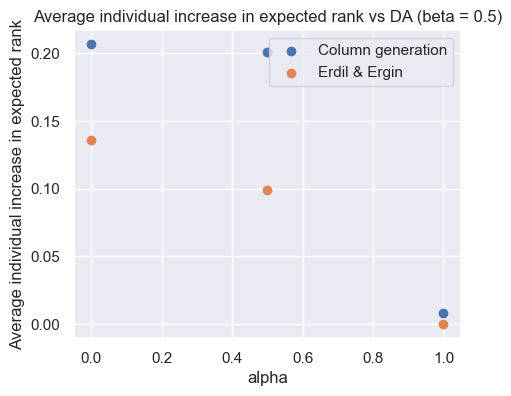

In [89]:
SimulationsEvaluate(S_vector, name, False)

## Estonian data

In [ ]:
file_path = "ReadData/Estonia/data_anon.txt" 
MyData = read_dataEstonia(file_path)
print(MyData)

In [ ]:
# Generate the assignment from DA with Single Tie-Breaking with n_iter samples
n_iter = 1000
bool_SIC = False # Run SICs immediately?
A = DA_STB(MyData, n_iter, 'GS', bool_SIC, 0, True)

# Find Stable improvement cycles à la Erdil and Ergin (2008)
A_SIC = SIC_all_matchings(MyData, A, True)
print(A.assignment)

In [ ]:
# Solve the formulations
MyModel = ModelColumnGen(MyData, A_SIC, A.assignment, True)
timeLimit = 3600
q = MyModel.Solve("TRAD", "GUROBI", print_log=False, time_limit=timeLimit, print_out=True)
#q = MyModel.Solve("STABLE", "GUROBI", True)

In [ ]:
# Generate a second subset of matchings, and test column generation with that
# (10 June 2025: not yet configured for use of warm start)
n_iter = 1000
bool_SIC = True # Run SICs immediately?
B = DA_STB(MyData, n_iter, 'GS', bool_SIC, 1, True)
B_SIC = SIC_all_matchings(MyData, B, True)
A_SIC.M_set = copy.deepcopy(B_SIC.M_set)
MyModel2 = ModelColumnGen(MyData, A_SIC, A.assignment, True)
qq = MyModel2.Solve("TRAD", "GUROBI", print_log=True, print_out=False)


## Run initial IP on generated data
Specify the number of students and schools, and run the models for this data.

In [ ]:
# Generate random data
parameters = DataGenParam(mean_pref = 6, capacity_ratio = 1) # Default parameters, except for mean_pref and capacity_ratio
#MyData = generate_data(n_students=400, n_schools=20, parameters = parameters, name="Test_DataGen", print_data=False, seed = 15)
MyData = generate_data(n_students=1000, n_schools=50, parameters = parameters, name="Test_DataGen_EE_vs_GS", print_data=False, seed = 0)

In [ ]:
# Print data if desired
print(MyData)

In [ ]:
# Generate the assignment from DA with Single Tie-Breaking with n_iter samples
n_iter = 20
bool_SIC = True # Run SICs immediately?
A = DA_STB(MyData, n_iter, 'GS', bool_SIC, 0, True)
print(A.assignment)

In [ ]:
# Solve the formulations
    # 'IMPR_RANK' refers to minimizing the expected rank while ensuring ex-post stability
    # 'STABLE' refers to maximizing the fraction of STABLE matchings in the decomposition
MyModel = Model(MyData, A, True)
q = MyModel.Solve("IMPR_RANK", "GUROBI", True)
#q = MyModel.Solve("STABLE", "GUROBI", True)

In [ ]:
# Print the solution
MyModel.print_solution()

In [ ]:
# Asses and visualize the difference
name_diff = name + '_diff'
diff = Assignment(MyData, q.assignment - A.assignment, name_diff)
diff.visualize()

## Heuristic subset weakly stable matchings
Runs an LP that minimizes the average rank while stochastically dominating the DA assignment with single-tie breaking, and while only using matchings that were used to compute DA probabilities. This is a heuristic.

In [ ]:
# Generate random data
parameters = DataGenParam(mean_pref = 5, capacity_ratio = 1) # Default parameters, except for mean_pref and capacity_ratio
#MyData = generate_data(n_students=400, n_schools=20, parameters = parameters, name="Test_DataGen", print_data=False, seed = 15)
MyData = generate_data(n_students=10, n_schools=4, parameters = parameters, name="500_25", print_data=False, seed = 1)

In [ ]:
# Print data if desired
print(MyData)

In [ ]:
# Generate the assignment from DA with Single Tie-Breaking with n_iter samples
n_iter = 1000
bool_SIC = True # Run SICs immediately?
A = DA_STB(MyData, n_iter, 'GS', bool_SIC, 0, True)
print(A.assignment)

In [ ]:
# Solve the formulations
    # 'IMPR_RANK' refers to minimizing the expected rank while ensuring ex-post stability
MyModel = ModelHeuristicLP(MyData, A, True)
q = MyModel.Solve("IMPR_RANK", "GUROBI", True)
#q = MyModel.Solve("STABLE", "GUROBI", True)

In [ ]:
# Print the solution
MyModel.print_solution()

In [ ]:
print(np.max(q.assignment-A.assignment))

In [ ]:
# Asses and visualize the difference
diff = Assignment(MyData, q.assignment - A.assignment, "40_12_Diff")
diff.visualize()

## Heuristic Fractional stable random matching

In [ ]:
# Solve the formulations
    # 'IMPR_RANK' refers to minimizing the expected rank while ensuring ex-post stability
MyModelFS = ModelFracStable(MyData, A, True)
q = MyModelFS.Solve("IMPR_RANK", "GUROBI", True)
#q = MyModel.Solve("STABLE", "GUROBI", True)

In [ ]:
# FInd decomposition over weakly stable matchings of this fractionally stable matching (if decomposition exists)
MyModelCHECK = Model(MyData, q, True)
q_check = MyModelCHECK.Solve("STABLE", "GUROBI", True)

## Run code manual data
Manually enter data.

In [ ]:
# Define preferences of the students
# 'pref[i][k]' contains the position of the k-th ranked school in the preferences.
# We assume the preferences to be strict
# Note that preferences can be strict. We indicate this by a tuple () in the list.

# Example paper
n_stud = 4
n_schools = 4

file_name = "Ex_paper"

# Preferences students
pref = [['1', '3', '4', '2'],
       ['1','4','3','2'],
       # ['1', '4'],
       ['2','3', '4', '1'],
       ['2', '4', '3', '1']]

# Priorities schools
prior = [[('A', 'B'), 'C', 'D'],
        [('C', 'D'), 'A', 'B'],
        ['B', 'D', ('A', 'C')],
        ['A', 'C', ('B', 'D')]]


# Capacities schools
cap = [1,1,1,1]

# Names of students and schools
ID_stud = ["A", "B", "C", "D"]
ID_school = ["1", "2", "3", "4"]

# Also create the random matching upon which we want to improve
p = np.zeros(shape=(n_stud, n_schools))
p[0][0] = 1/2
p[1][0] = 1/2
p[2][1] = 1/2
p[3][1] = 1/2
p[0][2] = 3/8
p[2][2] = 3/8
p[1][3] = 3/8
p[3][3] = 3/8
p[0][3] = 1/8
p[2][3] = 1/8
p[1][2] = 1/8
p[3][2] = 1/8

In [ ]:
# Generate a data instance (and print it)
MyData = Data(n_stud, n_schools, pref, prior, cap, ID_stud, ID_school, file_name)
print(MyData)


In [ ]:
# Generate an Assignment instance (and visualize it)
A = Assignment(MyData, p, "Ex_paper")

# To visualize assignment
A.visualize()

In [ ]:
# Solve the formulations
    # 'IMPR_RANK' refers to minimizing the expected rank while ensuring ex-post stability
    # 'STABLE' refers to maximizing the fraction of STABLE matchings in the decomposition
MyModel = Model(MyData, A, False)
q = MyModel.Solve("IMPR_RANK", "GUROBI", False)
#q = MyModel.Solve("STABLE", "GUROBI", True)

In [ ]:
# Print the solution
MyModel.print_solution()

In [ ]:
# Asses and visualize the difference
diff = Assignment(MyData, q.assignment - p, "Ex_paper_Diff")
diff.visualize()

In [ ]:
tuple([1,2])

# Erdil & Ergin experiments

In [ ]:
# Define preferences of the students
# 'pref[i][k]' contains the position of the k-th ranked school in the preferences.
# We assume the preferences to be strict
# Note that preferences can be strict. We indicate this by a tuple () in the list.

# Example paper
n_stud = 4
n_schools = 4

file_name = "Ex_paper"

# Preferences students
pref = [['1', '3', '4', '2'],
       ['1','4','3','2'],
       # ['1', '4'],
       ['2','3', '4', '1'],
       ['2', '4', '3', '1']]

# Priorities schools
prior = [[('A', 'B'), 'C', 'D'],
        [('C', 'D'), 'A', 'B'],
        ['B', 'D', ('A', 'C')],
        ['A', 'C', ('B', 'D')]]


# Capacities schools
cap = [1,1,1,1]

# Names of students and schools
ID_stud = ["A", "B", "C", "D"]
ID_school = ["1", "2", "3", "4"]

# Also create the random matching upon which we want to improve
p = np.zeros(shape=(n_stud, n_schools))
p[0][0] = 1/2
p[1][0] = 1/2
p[2][1] = 1/2
p[3][1] = 1/2
p[0][2] = 3/8
p[2][2] = 3/8
p[1][3] = 3/8
p[3][3] = 3/8
p[0][3] = 1/8
p[2][3] = 1/8
p[1][2] = 1/8
p[3][2] = 1/8

# Generate a data instance (and print it)
MyData = Data(n_stud, n_schools, pref, prior, cap, ID_stud, ID_school, file_name)
print(MyData)


In [ ]:
# Do tie-breaking
permut = generate_permutations_STB(MyData, 1, seed = 3)

prior_new = generate_strict_prior_from_perturbation(MyData, permut[0])

Data_new_prior = Data(MyData.n_stud, MyData.n_schools, MyData.pref, prior_new, MyData.cap, MyData.ID_stud, MyData.ID_school, MyData.file_name)

# DA code Erdil & Ergin
N = transform_pref_us_to_EE(Data_new_prior)
A = transform_prior_us_to_EE(Data_new_prior)
Q = MyData.cap
result = DA_Erdil_ergin(N,A,Q)
print(result)
print(type(result['proposeoffset']))

M = gale_shapley(Data_new_prior)
print(type(M))
print(M)

M = np.zeros((4,4))
M[0,1] = 1
M[1,2] = 1
M[2,3] = 1
M[3,0] = 1
print(M)
print(M[0,1] == 1)

M_out = SIC(MyData, M, False)
print(M_out)

In [ ]:
bool_SIC = False # Run SICs immediately?
AssignmentGS = DA_STB(MyData, 10, 'GS', bool_SIC, 0)
ASIC = SIC_all_matchings(MyData, AssignmentGS, True)

print(AssignmentGS.assignment)




# Quick tests


In [ ]:
n_stud = 2000
n_schools = 30
pref_list_length = n_schools
alpha_in = 0.2
beta_in = 0
seed = 1
MyData = DataGenEE(n_stud, n_schools, alpha_in, beta_in, pref_list_length, True, seed)
print(MyData)


In [ ]:
ALPHA_INCREMENT = 0.2
BETA_INCREMENT = 0.4

alpha_list = list(np.arange(0, 1.0, ALPHA_INCREMENT)) 
beta_list = list(np.arange(0, 1.0, BETA_INCREMENT))

print(alpha_list)
print(type(alpha_list))
